# Sentiment Analysis

In [13]:
# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
from datasets import Dataset, DatasetDict
# from datasets import load_dataset
# import evaluate

import transformers
from transformers import BertTokenizerFast, DataCollatorForTokenClassification, AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline, TFBertForSequenceClassification, create_optimizer


from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization, Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam


In [14]:
df_nlp = pd.read_csv('../data/bank_reviews3.csv')
df_nlp.columns
pd.unique(df_nlp['rating']) # 10 ratings
df_nlp.shape
# df_nlp['rating'].value_counts()

(1000, 10)

In [15]:
train_df = df_nlp.iloc[0:900, ]
test_df = df_nlp.iloc[900:, ]
train_reviews = train_df['review']
train_target = train_df['rating']
x_test = test_df['review']
y_test = test_df['rating']

# Split data into train and validation
x_train, x_val, y_train, y_val = train_test_split(train_reviews, train_target,
                 test_size = 0.2)

train_dataset = Dataset.from_dict({'text': x_train,
                                   'label': y_train})
test_dataset = Dataset.from_dict({'text':x_test,
                                 'label': y_test})
val_dataset = Dataset.from_dict({'text':x_val,
                                 'label':y_val})
dataset = DatasetDict({
    'train':train_dataset,
    'val':val_dataset,
    'test':test_dataset
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 720
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 180
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
})


In [16]:
# Tokenization
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encoding
max_len = 128
x_train_encoded = tokenizer.batch_encode_plus(x_train.tolist(),
                                              padding = True,
                                              truncation = True,
                                              max_length = max_len,
                                              return_tensors = 'tf')

x_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                            padding  = True,
                                            truncation = True,
                                            max_length = max_len,
                                            return_tensors = 'tf')

x_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                             padding = True,
                                             truncation = True,
                                             max_length = max_len,
                                             return_tensors  ='tf')

In [17]:
# from sklearn.preprocessing import MinMaxScaler

In [18]:
# scaler = MinMaxScaler()
# x_train_scaled= scaler.fit_transform(x_train_encoded['input_ids'])
# x_train_scaled= tf.convert_to_tensor(x_train_scaled, dtype = tf.float32)
# x_val_scaled = scaler.fit_transform(x_val_encoded['input_ids'])
# x_val_scaled = tf.convert_to_tensor(x_val_scaled, dtype = tf.float32)

# # Replace the original x_train_encoded
# x_train_encoded['input_ids'] = x_train_scaled
# x_val_encoded['input_ids'] = x_val_scaled

In [19]:
tokenizer.decode(x_test_encoded['input_ids'][1])

"[CLS] i ' m having my savings account with kotak mahindra bank. since its a zero balance account so that i had selected this bank. on yearly once, they are charging rs. 200 for the debit card. once i had faced a issue like they have blocked my account due to signature mismatch. once i visited their branch, they said it will take one week to resolve my issue. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [20]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.summary()

# Compile the model with a regression loss function
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
              
model.summary()

# Train the model
history = model.fit(
    x_train_encoded['input_ids'],
    y_train,
    validation_data=(x_val_encoded['input_ids'], y_val),
    epochs=5,
    batch_size=16
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
  

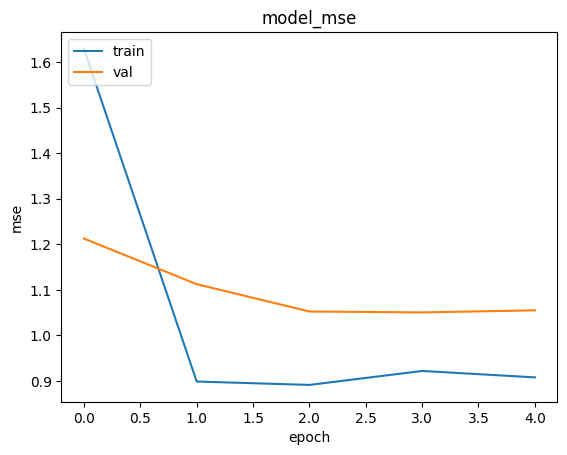

In [21]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model_mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Test on test data
predictions = model.predict(x_test_encoded['input_ids'])


4/4 [==============================] - 39s 6s/step


In [23]:
predicted_ratings = predictions.logits.flatten()
predicted_ratings_rounded = tf.round(predicted_ratings).numpy()

print("Predicted Ratings (Continuous):", predicted_ratings[:5])

Predicted Ratings (Continuous): [4.3491497 4.3491497 4.3491497 4.3491497 4.3491497]


In [24]:
predicted_ratings

array([4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497, 4.3491497,
       4.3491497, 4.3491497, 4.3491497, 4.3491497, 

In [25]:
y_test

900    2.0
901    5.0
902    5.0
903    5.0
904    5.0
      ... 
995    3.5
996    4.0
997    4.0
998    5.0
999    4.0
Name: rating, Length: 100, dtype: float64